In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
file_path = '/content/filled_data1 (1).csv'
data = pd.read_csv(file_path)

# Define seasons
seasons = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

# Assign season to each row
def get_season(month):
    for season, months in seasons.items():
        if month in months:
            return season
    return 'Unknown'

data['Season'] = data['month'].apply(get_season)

# Ensure total number of rows is 40,000
if len(data) < 40000:
    additional_data_needed = 40000 - len(data)
    data = pd.concat([data, data.sample(additional_data_needed, replace=True)])
else:
    data = data.sample(40000)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Prepare data for GAN
features = data.drop(columns=['Season'])
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Define GAN architecture
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(features_scaled.shape[1], activation='tanh'))
    return model

def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_shape=(features_scaled.shape[1],)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile GAN
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

generator = build_generator()
z = tf.keras.Input(shape=(100,))
img = generator(z)

discriminator.trainable = False
valid = discriminator(img)

combined = tf.keras.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer='adam')

# Train GAN
def train_gan(epochs, batch_size=128):
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        idx = np.random.randint(0, features_scaled.shape[0], half_batch)
        real_imgs = features_scaled[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)

        g_loss = combined.train_on_batch(noise, valid_y)

        if epoch % 1000 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")

train_gan(epochs=10000)

# Generate new data
noise = np.random.normal(0, 1, (10000, 100))
gen_data = generator.predict(noise)
gen_data = scaler.inverse_transform(gen_data)

# Convert generated data to DataFrame
gen_data_df = pd.DataFrame(gen_data, columns=features.columns)

# Combine original and generated data
combined_data = pd.concat([data, gen_data_df]).reset_index(drop=True)

# Save to CSV
output_file_path = 'seasonal_data_with_gan.csv'
combined_data.to_csv(output_file_path, index=False)


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 11ms/step
8000 [D loss: 0.5121202170848846] [G loss: 1.7631876468658447]
2/2 [==============================] - 0s 10ms/step
9000 [D loss: 0.5367579162120819] [G loss: 1.3188120126724243]
9000 [D loss: 0.5367579162120819] [G loss: 1.3188120126724243]
313/313 [==============================] - 2s 6ms/step


In [11]:
# Save to CSV
output_file_path = 'seasonal_data_with_gan1.csv'
combined_data.to_csv(output_file_path, index=False)


   Temperature  Humidity  ALLSKY_SFC_UVB  ALLSKY_SFC_UV_INDEX  ALLSKY_SFC_UVA  \
0         28.0  0.946667        0.020000              0.08000         3.32000   
1         27.0  0.480000        1.560000              8.15000        42.53000   
2         25.0  0.883333        0.020000              0.08000         3.30000   
3         33.0  0.583333        2.190000             12.25000        56.45000   
4         27.0  0.963333        0.373759              1.95089        12.15514   

    QV2M   RH2M  PRECTOTCORR  WS10M    year  month   day  hour  weekday  \
0  19.35  72.12       0.3000   1.42  2010.0    4.0  15.0  19.0      3.0   
1  18.74  71.88       0.9000   3.27  2010.0    4.0   8.0  14.0      3.0   
2  19.04  89.25       1.4700   3.17  2010.0    8.0  19.0  19.0      3.0   
3  19.35  67.56       0.2529   2.37  2010.0    4.0  30.0  14.0      4.0   
4  19.29  87.44       0.0400   1.84  2010.0    3.0  30.0  22.0      1.0   

   Inflation     Load  Season  
0       1.62  52892.0  Spring 

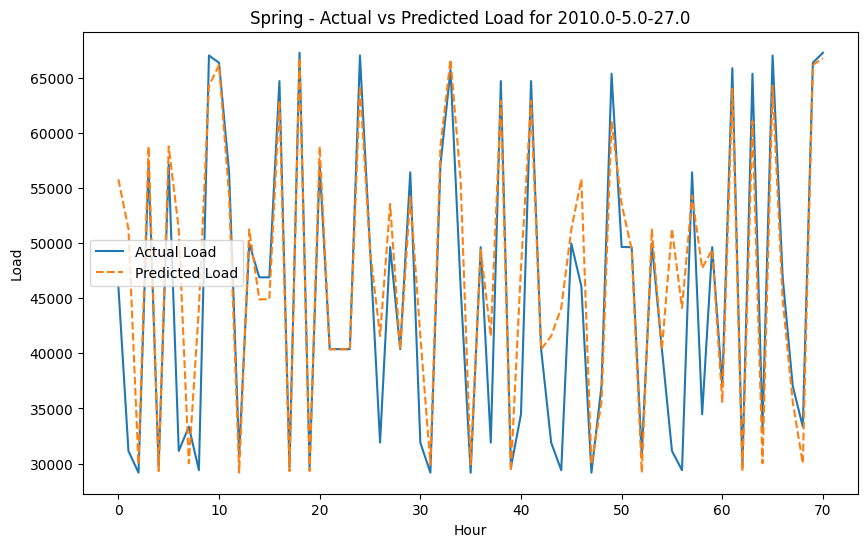

2/2 [==============================] - 0s 6ms/step


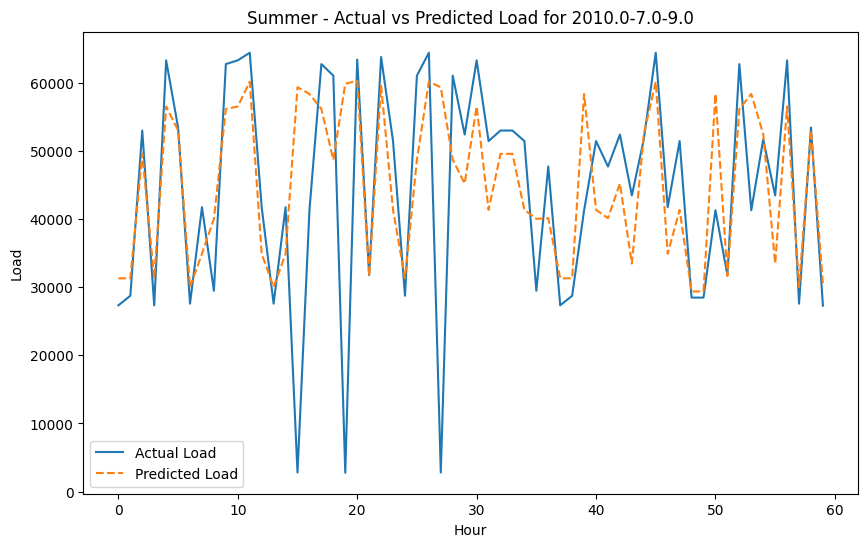

2/2 [==============================] - 0s 8ms/step


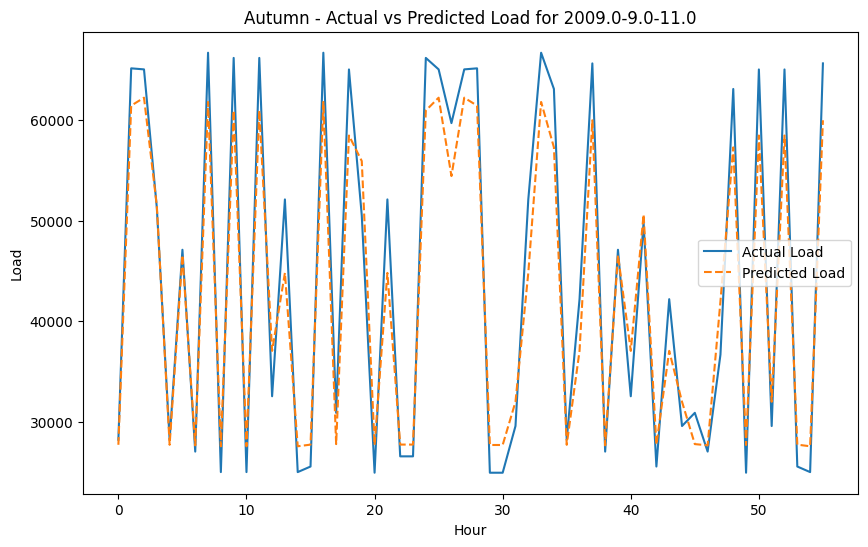

2/2 [==============================] - 0s 7ms/step


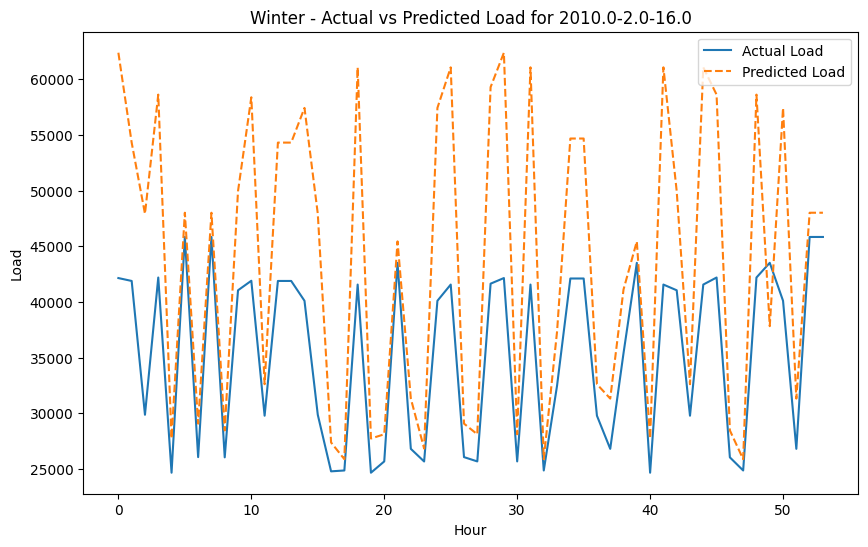

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Load and Inspect the Dataset
# Load the dataset
file_path = 'seasonal_data_with_gan1.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

# Check for any missing or infinite values
print(data.isnull().sum())

# Step 2: Clean the Data
# Drop rows with missing or infinite values
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

# Display the first few rows of the updated dataset
print(data.head())

# Step 3: Prepare and Scale the Data
# Define seasons
seasons = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

# Assign season to each row
def get_season(month):
    for season, months in seasons.items():
        if month in months:
            return season
    return 'Unknown'

data['Season'] = data['month'].apply(get_season)

# Prepare the data
features = data.drop(columns=['Load', 'Season'])
target = data['Load']

# Scale the features and target
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target = target.values.reshape(-1, 1)
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target)

# Step 4: Train LSTM Model and Evaluate Performance
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, random_state=42)

# Reshape data for LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Predictions
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# Calculate R2 and RMSE
r2 = r2_score(y_test_actual, y_pred)
rmse = mean_squared_error(y_test_actual, y_pred, squared=False)

# Print R2 and RMSE
print(f'R2: {r2}')
print(f'RMSE: {rmse}')

# Step 5: Plot Seasonal Graphs
# Helper function to plot actual vs predicted for a random day
def plot_random_day_lstm(season, season_months):
    # Filter data for the specified season
    season_data = data[data['month'].isin(season_months)]
    # Select a random day
    random_day = season_data.sample(n=1)
    year = random_day.iloc[0]['year']
    month = random_day.iloc[0]['month']
    day = random_day.iloc[0]['day']
    day_data = season_data[(season_data['year'] == year) & (season_data['month'] == month) & (season_data['day'] == day)]

    # Prepare the data
    X_day = day_data.drop(columns=['Load', 'Season'])
    y_day_actual = day_data['Load']
    X_day_scaled = scaler.transform(X_day)
    X_day_scaled = np.reshape(X_day_scaled, (X_day_scaled.shape[0], 1, X_day_scaled.shape[1]))
    y_day_pred_scaled = model.predict(X_day_scaled)
    y_day_pred = target_scaler.inverse_transform(y_day_pred_scaled)

    # Plot the actual vs predicted load for this day
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_day_actual)), y_day_actual, label='Actual Load')
    plt.plot(range(len(y_day_actual)), y_day_pred, label='Predicted Load', linestyle='--')
    plt.xlabel('Hour')
    plt.ylabel('Load')
    plt.title(f'{season} - Actual vs Predicted Load for {year}-{month}-{day}')
    plt.legend()
    plt.show()

# Plot for each season
for season, months in seasons.items():
    plot_random_day_lstm(season, months)


2/2 [==============================] - 0s 6ms/step


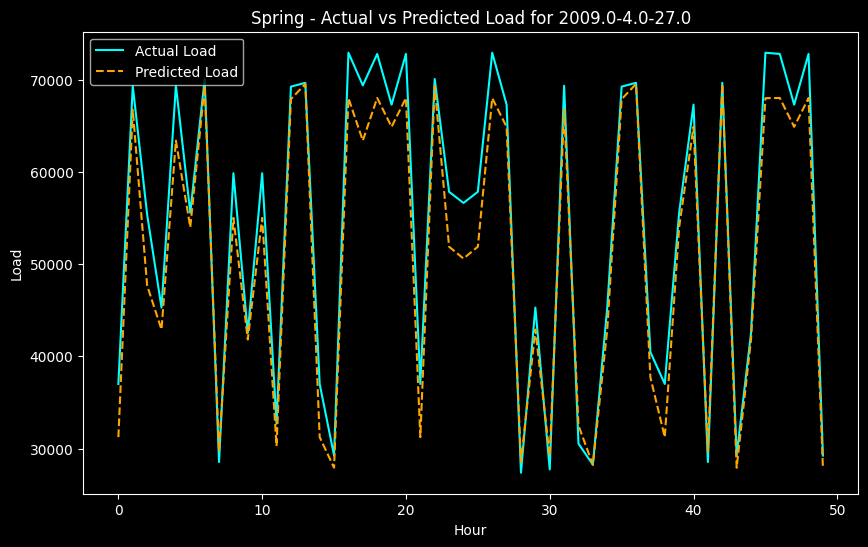

2/2 [==============================] - 0s 9ms/step


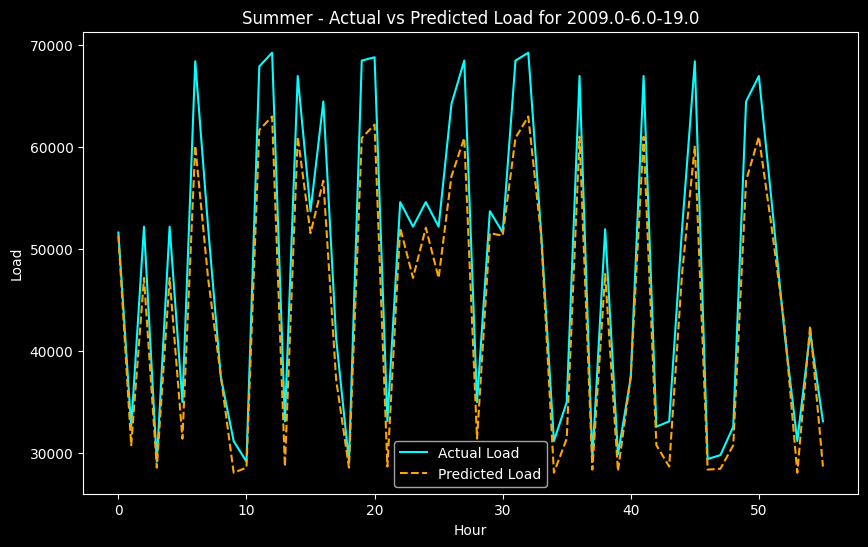

2/2 [==============================] - 0s 6ms/step


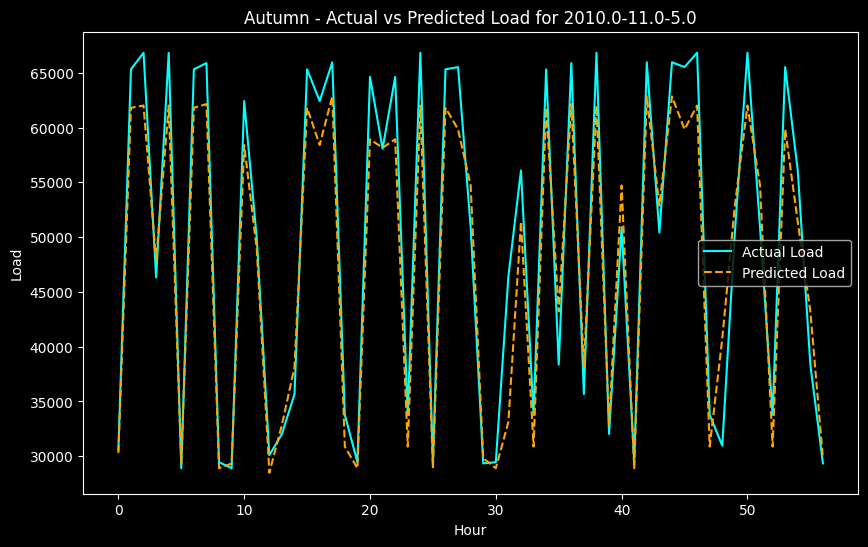

2/2 [==============================] - 0s 13ms/step


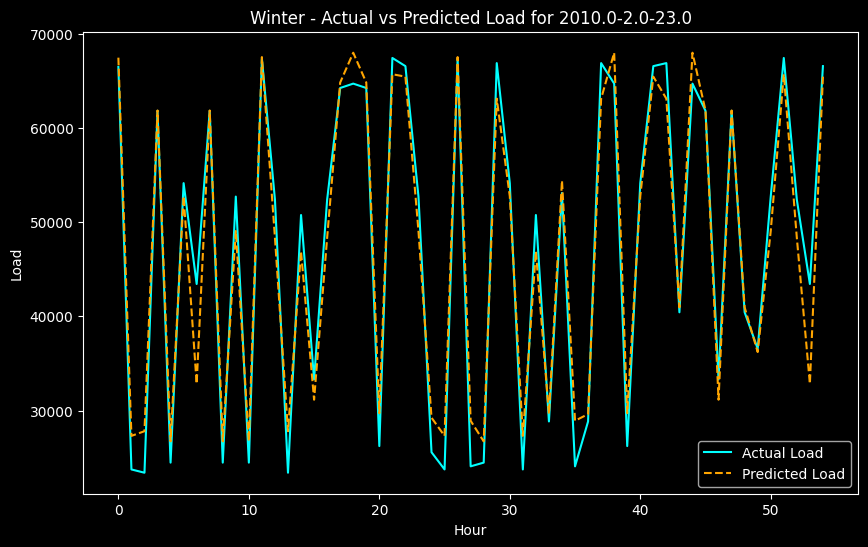

In [5]:
import matplotlib.pyplot as plt

# Helper function to plot actual vs predicted for a random day with a dark theme
def plot_random_day_lstm(season, season_months):
    plt.style.use('dark_background')  # Set the plot style to dark
    # Filter data for the specified season
    season_data = data[data['month'].isin(season_months)]
    # Select a random day
    random_day = season_data.sample(n=1)
    year = random_day.iloc[0]['year']
    month = random_day.iloc[0]['month']
    day = random_day.iloc[0]['day']
    day_data = season_data[(season_data['year'] == year) & (season_data['month'] == month) & (season_data['day'] == day)]

    # Prepare the data
    X_day = day_data.drop(columns=['Load', 'Season'])
    y_day_actual = day_data['Load']
    X_day_scaled = scaler.transform(X_day)
    X_day_scaled = np.reshape(X_day_scaled, (X_day_scaled.shape[0], 1, X_day_scaled.shape[1]))
    y_day_pred_scaled = model.predict(X_day_scaled)
    y_day_pred = target_scaler.inverse_transform(y_day_pred_scaled)

    # Plot the actual vs predicted load for this day
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_day_actual)), y_day_actual, label='Actual Load', color='cyan')
    plt.plot(range(len(y_day_actual)), y_day_pred, label='Predicted Load', linestyle='--', color='orange')
    plt.xlabel('Hour', color='white')
    plt.ylabel('Load', color='white')
    plt.title(f'{season} - Actual vs Predicted Load for {year}-{month}-{day}', color='white')
    plt.legend()
    plt.show()

# Plot for each season
for season, months in seasons.items():
    plot_random_day_lstm(season, months)


R2: 0.9843898015509792
RMSE: 1921.8415582379935


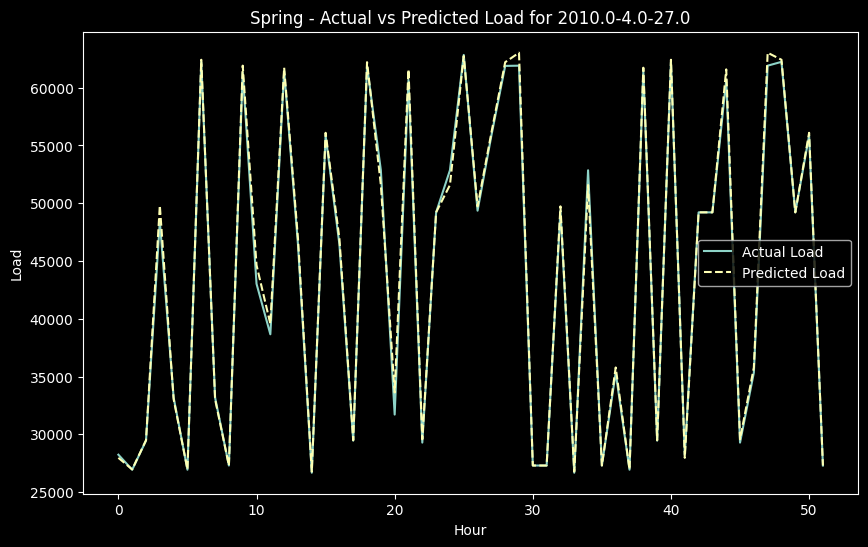

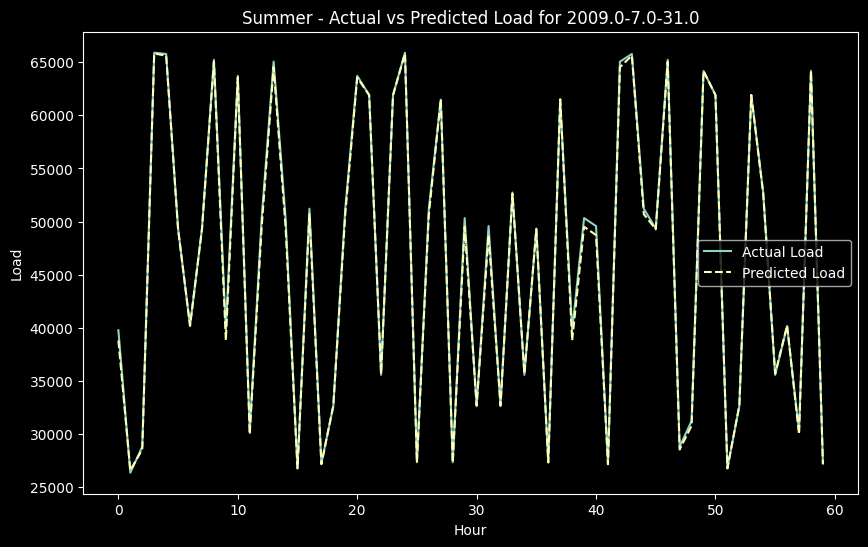

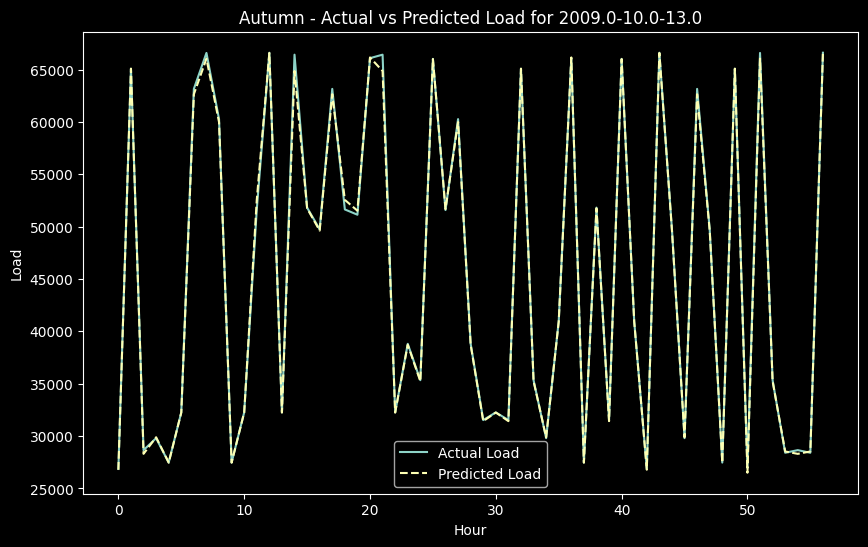

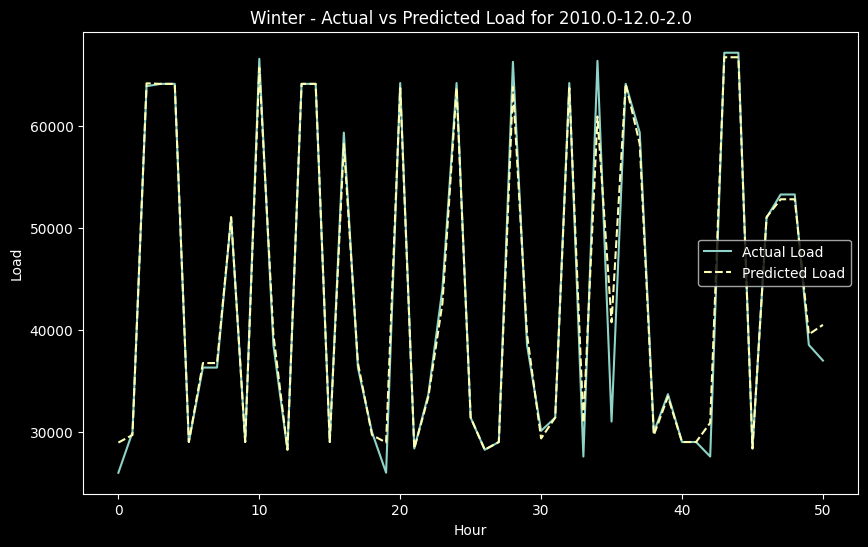

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Load the dataset
file_path = 'seasonal_data_with_gan1.csv'
data = pd.read_csv(file_path)

# Define seasons
seasons = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

# Assign season to each row
def get_season(month):
    for season, months in seasons.items():
        if month in months:
            return season
    return 'Unknown'

data['Season'] = data['month'].apply(get_season)

# Prepare the data
features = data.drop(columns=['Load', 'Season'])
target = data['Load']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Calculate R2 and RMSE
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print R2 and RMSE
print(f'R2: {r2}')
print(f'RMSE: {rmse}')

# Helper function to plot actual vs predicted for a random day
def plot_random_day(season, season_months):
    # Filter data for the specified season
    season_data = data[data['month'].isin(season_months)]
    # Select a random day
    random_day = season_data.sample(n=1)
    year = random_day.iloc[0]['year']
    month = random_day.iloc[0]['month']
    day = random_day.iloc[0]['day']
    day_data = season_data[(season_data['year'] == year) & (season_data['month'] == month) & (season_data['day'] == day)]

    # Prepare the data
    X_day = day_data.drop(columns=['Load', 'Season'])
    y_day_actual = day_data['Load']
    y_day_pred = rf_model.predict(X_day)

    # Plot the actual vs predicted load for this day
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_day_actual)), y_day_actual, label='Actual Load')
    plt.plot(range(len(y_day_actual)), y_day_pred, label='Predicted Load', linestyle='--')
    plt.xlabel('Hour')
    plt.ylabel('Load')
    plt.title(f'{season} - Actual vs Predicted Load for {year}-{month}-{day}')
    plt.legend()
    plt.show()

# Plot for each season
for season, months in seasons.items():
    plot_random_day(season, months)


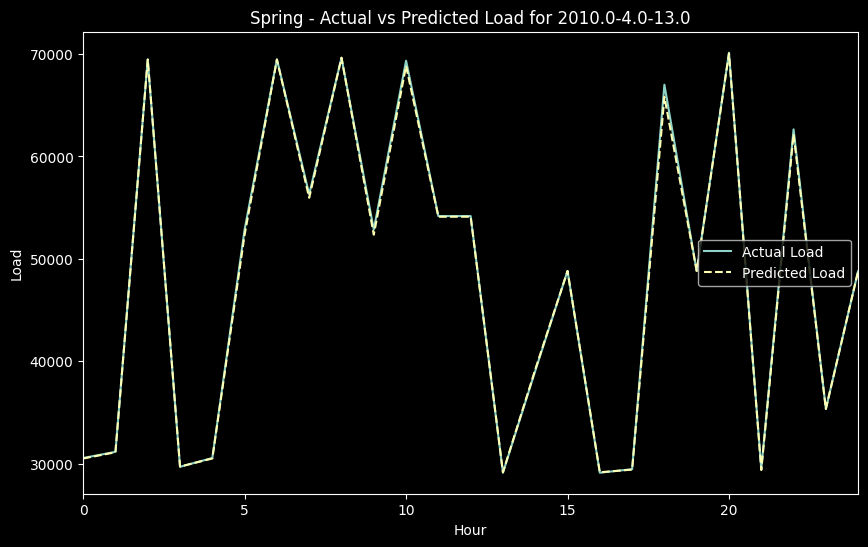

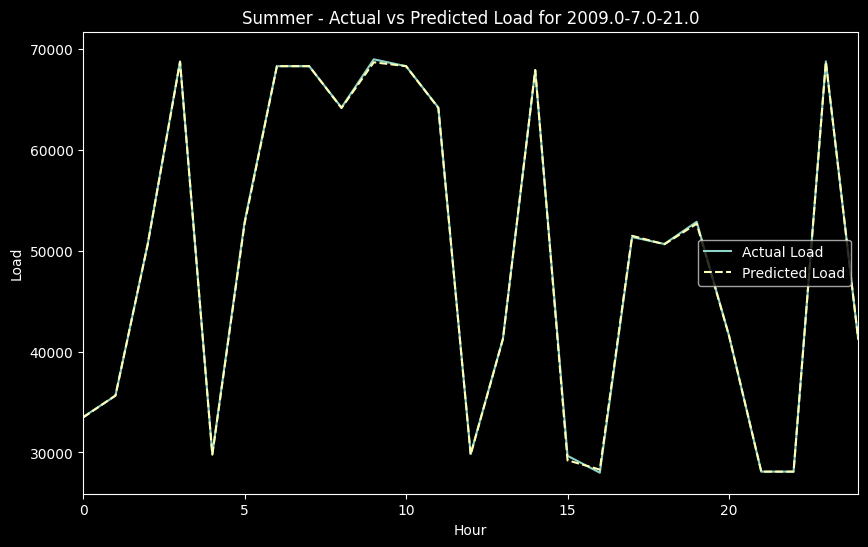

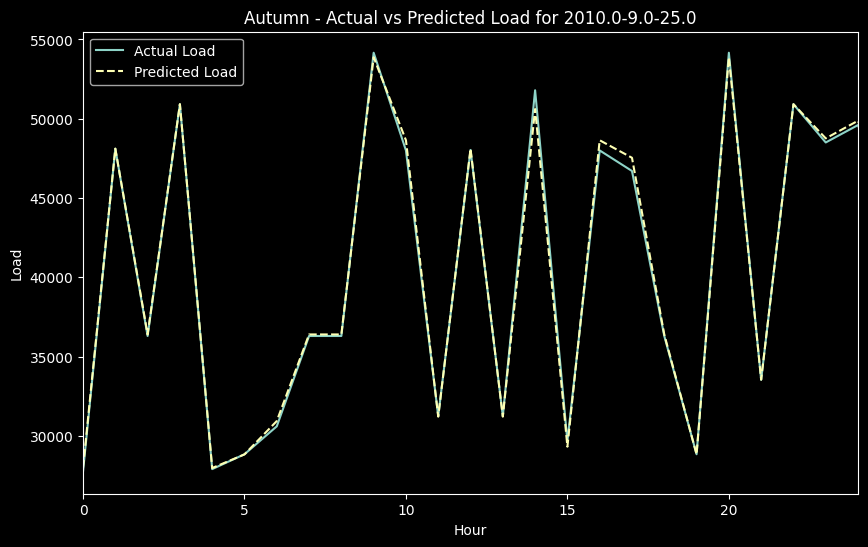

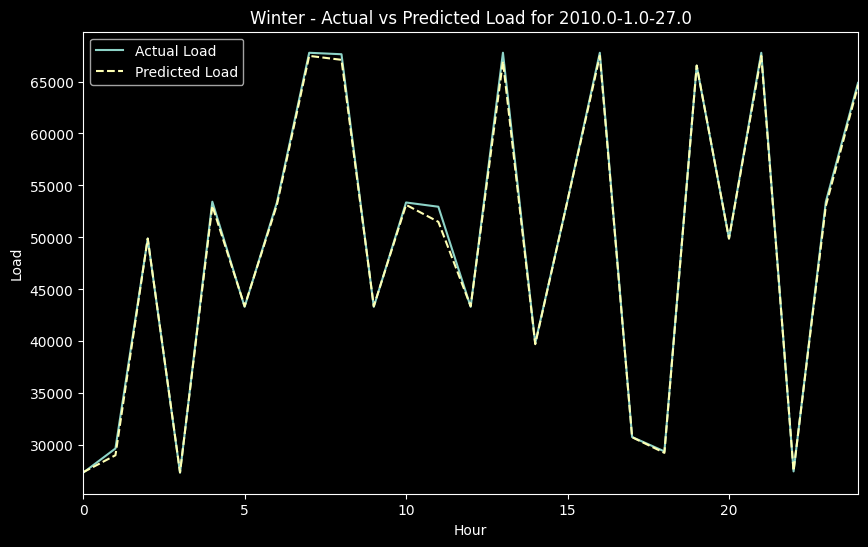

In [19]:

# Define seasons
seasons = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

# Assign season to each row
def get_season(month):
    for season, months in seasons.items():
        if month in months:
            return season
    return 'Unknown'

data['Season'] = data['month'].apply(get_season)
data

# Helper function to plot actual vs predicted for a random day
def plot_random_day(season, season_months):
    # Filter data for the specified season
    season_data = data[data['month'].isin(season_months)]
    # Select a random day
    random_day = season_data.sample(n=1)
    year = random_day.iloc[0]['year']
    month = random_day.iloc[0]['month']
    day = random_day.iloc[0]['day']
    day_data = season_data[(season_data['year'] == year) & (season_data['month'] == month) & (season_data['day'] == day)]

    # Prepare the data
    X_day = day_data.drop(columns=['Load', 'Season'])
    y_day_actual = day_data['Load']
    y_day_pred = rf_model.predict(X_day)

    # Plot the actual vs predicted load for this day
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_day_actual)), y_day_actual, label='Actual Load')
    plt.plot(range(len(y_day_actual)), y_day_pred, label='Predicted Load', linestyle='--')
    plt.xlabel('Hour')
    plt.ylabel('Load')
    plt.title(f'{season} - Actual vs Predicted Load for {year}-{month}-{day}')
    plt.legend()
    plt.xlim(0, 24)
    plt.show()

  # Plot for each season
for season, months in seasons.items():
    plot_random_day(season, months)